In [15]:
import os
import sys
import struct

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import KMeans, spectral_clustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from copy import deepcopy


In [16]:
os.chdir("/home/g.esposito/sc2-benchmark")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/g.esposito/sc2-benchmark") if file_path.startswith("FSIM_W_hpc_obj_v2_")]
# print(log_folders)

general_report = pd.DataFrame([])
for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store"]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                report.loc[idx, 'boxes_Crit'] = report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = report['boxes_Crit'] + report['boxes_SDC'] + report['boxes_Masked']
            # for val in tot_boxes_per_fault:
            #     if val == 0:
            #         print('queste sono tutte critiche')
            report['Crit_perc'] = (report['boxes_Crit'] / tot_boxes_per_fault)*100
            report['SDC_perc'] = (report['boxes_SDC'] / tot_boxes_per_fault)*100
            report['masked_perc'] = (report['boxes_Masked'] / tot_boxes_per_fault)*100
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)
    

    # general_report.loc[indices]['Crit_perc'].fillna(1, inplace=True)
    # general_report.loc[indices,'SDC_perc'].fillna(0, inplace=True)
    # general_report.loc[indices,'masked_perc'].fillna(0, inplace=True)

# indices = general_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0")
# print(indices)

general_report.shape
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')

## Distribution Analysis
- layer
- kernel
- channel
- row
- col
- BitMask
- gold_iou: Intersection over Union score of the golden model for each num_layers compression
- boxes_Crit: most of the faults does not produce any critical fault and the faults that produce more than 10 critical boxes are only 7
- boxes_SDC: for each fault the number of SDC boxes are almost the same (around 517) which is very high that means that often the faults affect the model producing a slightly different result with respect to the golden model. 
- boxes_Masked: only in few cases the boxes predicted by the faulty model has perfectly masked boxes. Actually looking at the mean, we can see that all the faults, on average, 2 or 3 masked boxes (not that much) (remember that each fault is tested over 100 images).
- fault_iou@1: all the predicted boxes have iou score of 87% with respect to the boxes predicted by the golden model
- area_ratio: the same holds for the ratio between the ratio between the golden and faulty model (the number shows that the faulty tends to underestimate the area of the predicted boxes of, on average 12%)
- average_golden_boxes: The average number of bounding boxes over all the images of the dataset is 5.06
- average_faulty_boxes: The average number of bounding boxes over all the images of the dataset is 5.44 which is similar to the one of the golden model
- average_target_boxes: the expected number of boxes for each image is 7.78
- Ffree_Weight
- Faulty_weight
- Abs_error
- conf_detail: label of the configuration (let us try to use it for the clustering)

In [17]:
print(general_report['bitmask'].unique())
np.log2(general_report['bitmask'].unique())

[   1048576  536870912   33554432   67108864 2147483648  134217728
 1073741824    8388608    4194304    2097152   16777216  268435456]


array([20., 29., 25., 26., 31., 27., 30., 23., 22., 21., 24., 28.])

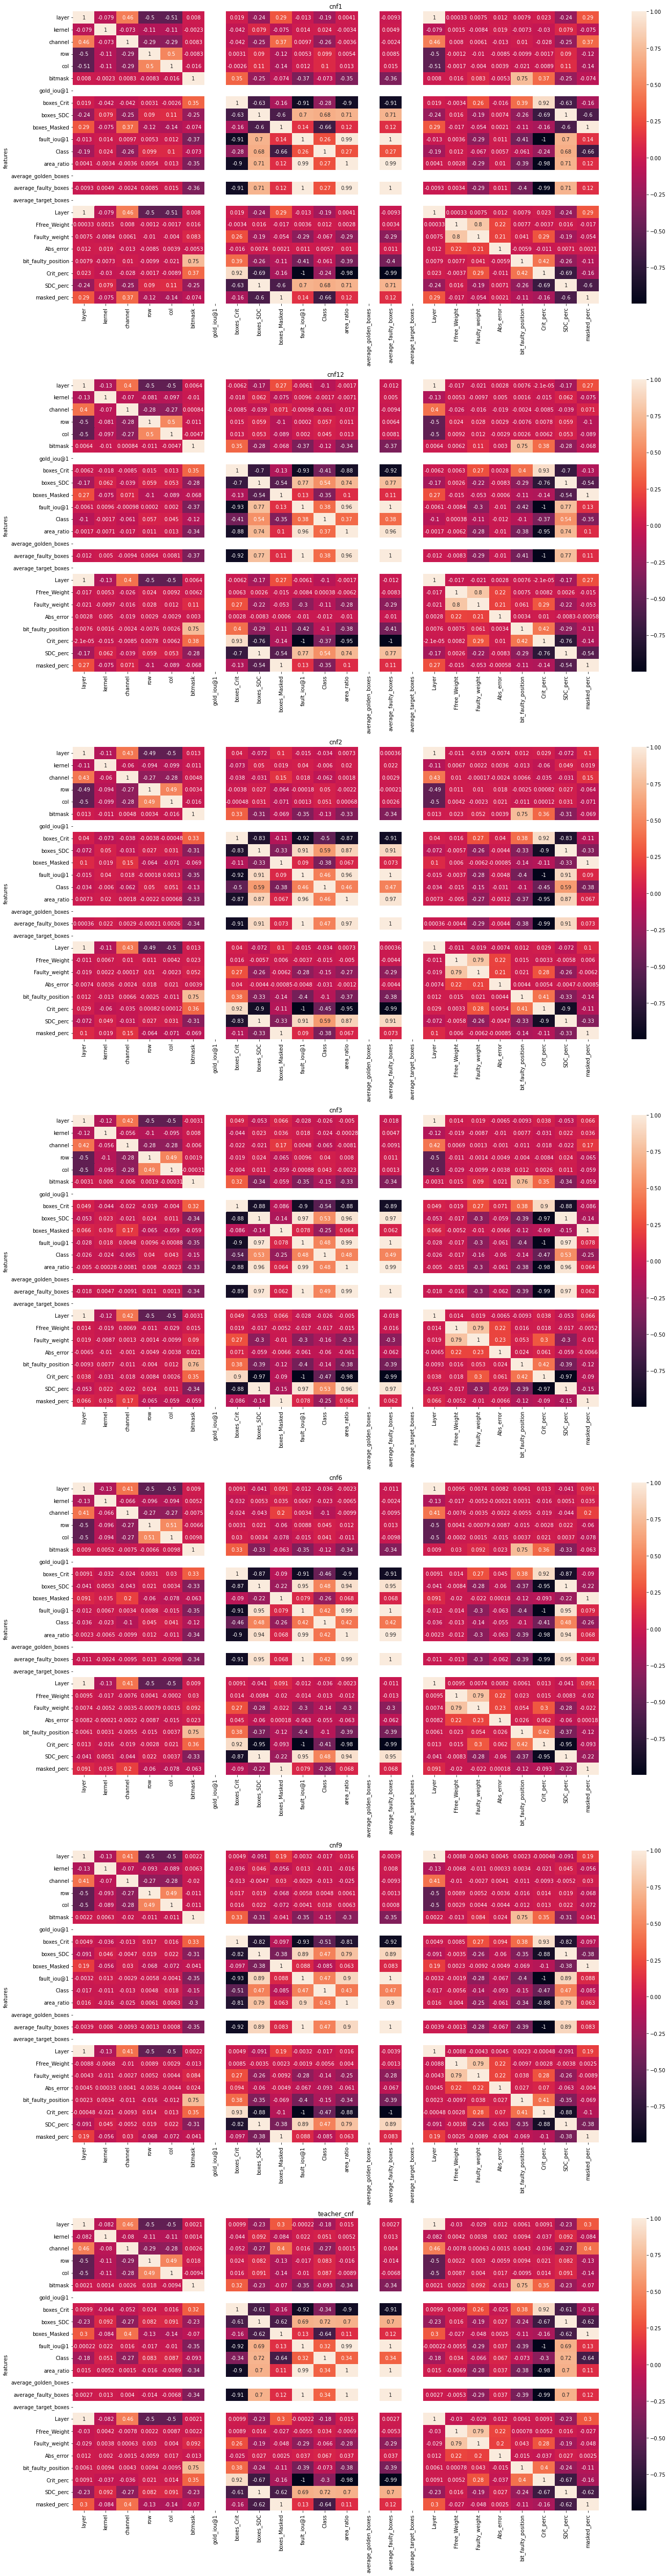

In [18]:
df_by_layer = general_report.groupby(by="conf_detail")

# for super_key, df in df_by_layer.groups.items():
#     print(super_key)
#     print(df)
corr_df = df_by_layer.corr()
fig, ax = plt.subplots(7,1, figsize=(20,70))
for i in range(len(list(df_by_layer.groups.keys()))):
    cnf = list(df_by_layer.groups.keys())[i]
    mini_corr_df = corr_df.loc[cnf, :]
    sns.heatmap(mini_corr_df,ax=ax[i], annot=True)
    ax[i].set_title(cnf)
    ax[i].set_ylabel("features")
plt.tight_layout()
    



In [19]:
# Define the desired order of the categories
desired_order = ['cnf1', 'cnf2', 'cnf3', 'cnf6', 'cnf9', 'cnf12', 'teacher_cnf']

# Sort the data by the categorical variable
general_report = general_report.sort_values(by='conf_detail')
general_report['conf_detail'] = general_report['conf_detail'].astype('category')
general_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)

<ipython-input-19-0eb8d35444be>:7: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  general_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)


In [20]:
# general_report.isna().sum()

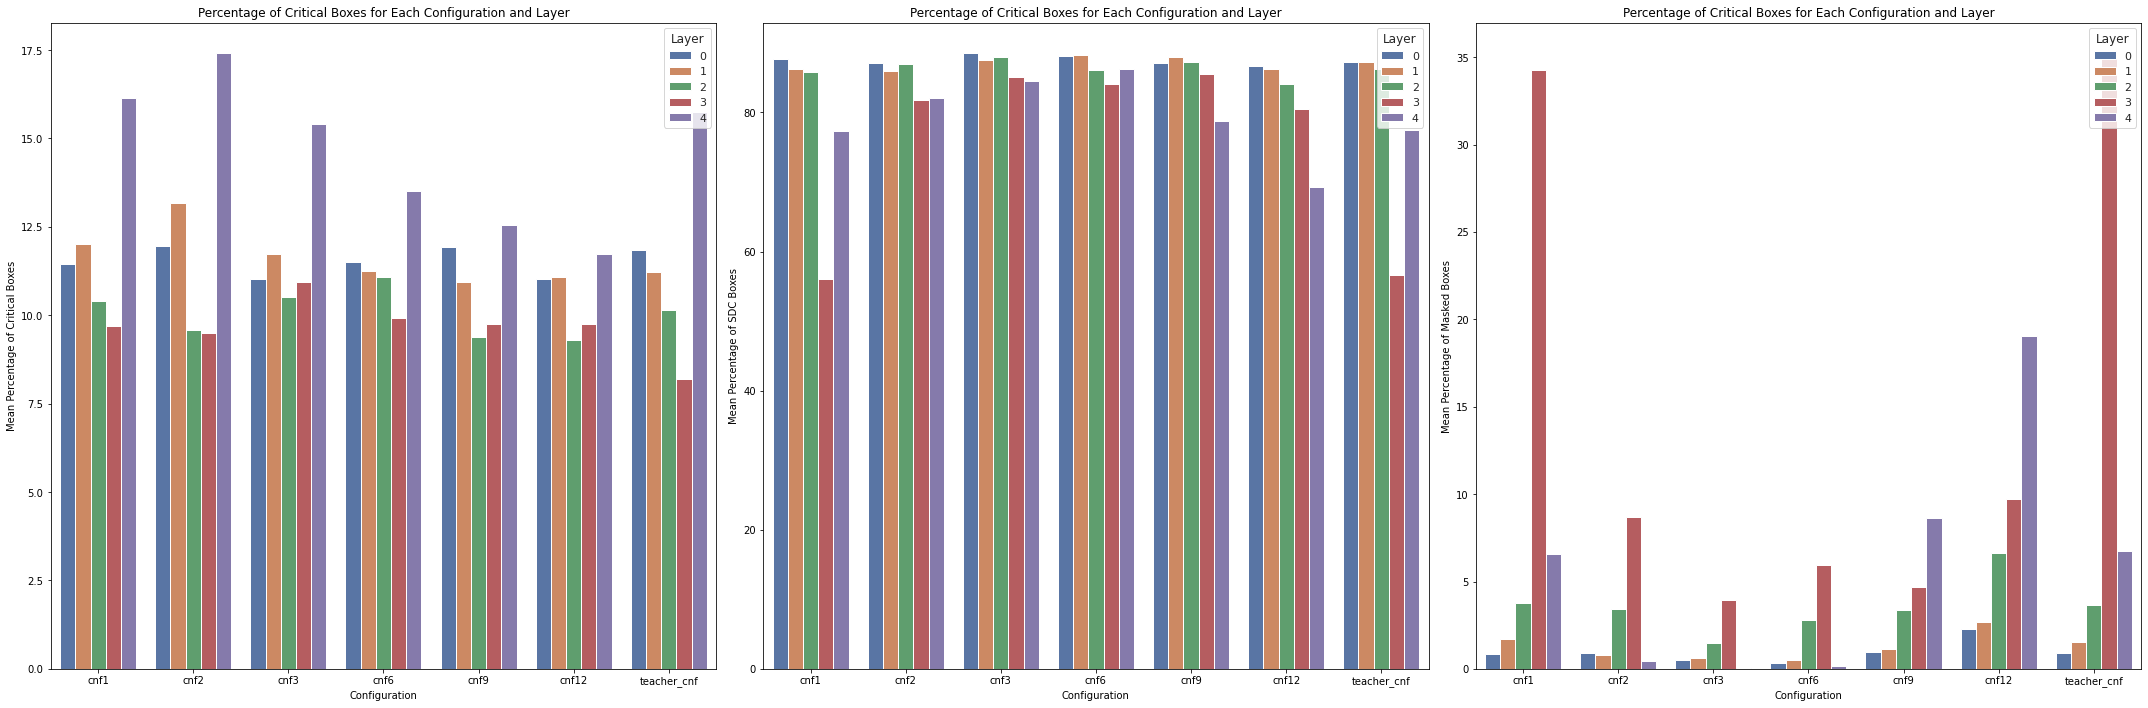

In [21]:
mean_percentages_crit = general_report.groupby(['conf_detail', 'layer'])['Crit_perc'].mean().reset_index()
mean_percentages_sdc = general_report.groupby(['conf_detail', 'layer'])['SDC_perc'].mean().reset_index()
mean_percentages_masked = general_report.groupby(['conf_detail', 'layer'])['masked_perc'].mean().reset_index()

fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='Crit_perc', hue='layer', data=mean_percentages_crit, ax = ax[0])
ax[0].set_xlabel('Configuration')
ax[0].set_ylabel('Mean Percentage of Critical Boxes')
ax[0].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[0].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='SDC_perc', hue='layer', data=mean_percentages_sdc, ax = ax[1])
ax[1].set_xlabel('Configuration')
ax[1].set_ylabel('Mean Percentage of SDC Boxes')
ax[1].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[1].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='masked_perc', hue='layer', data=mean_percentages_masked, ax = ax[2])
ax[2].set_xlabel('Configuration')
ax[2].set_ylabel('Mean Percentage of Masked Boxes')
ax[2].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[2].legend(title='Layer', loc='upper right')
plt.tight_layout()


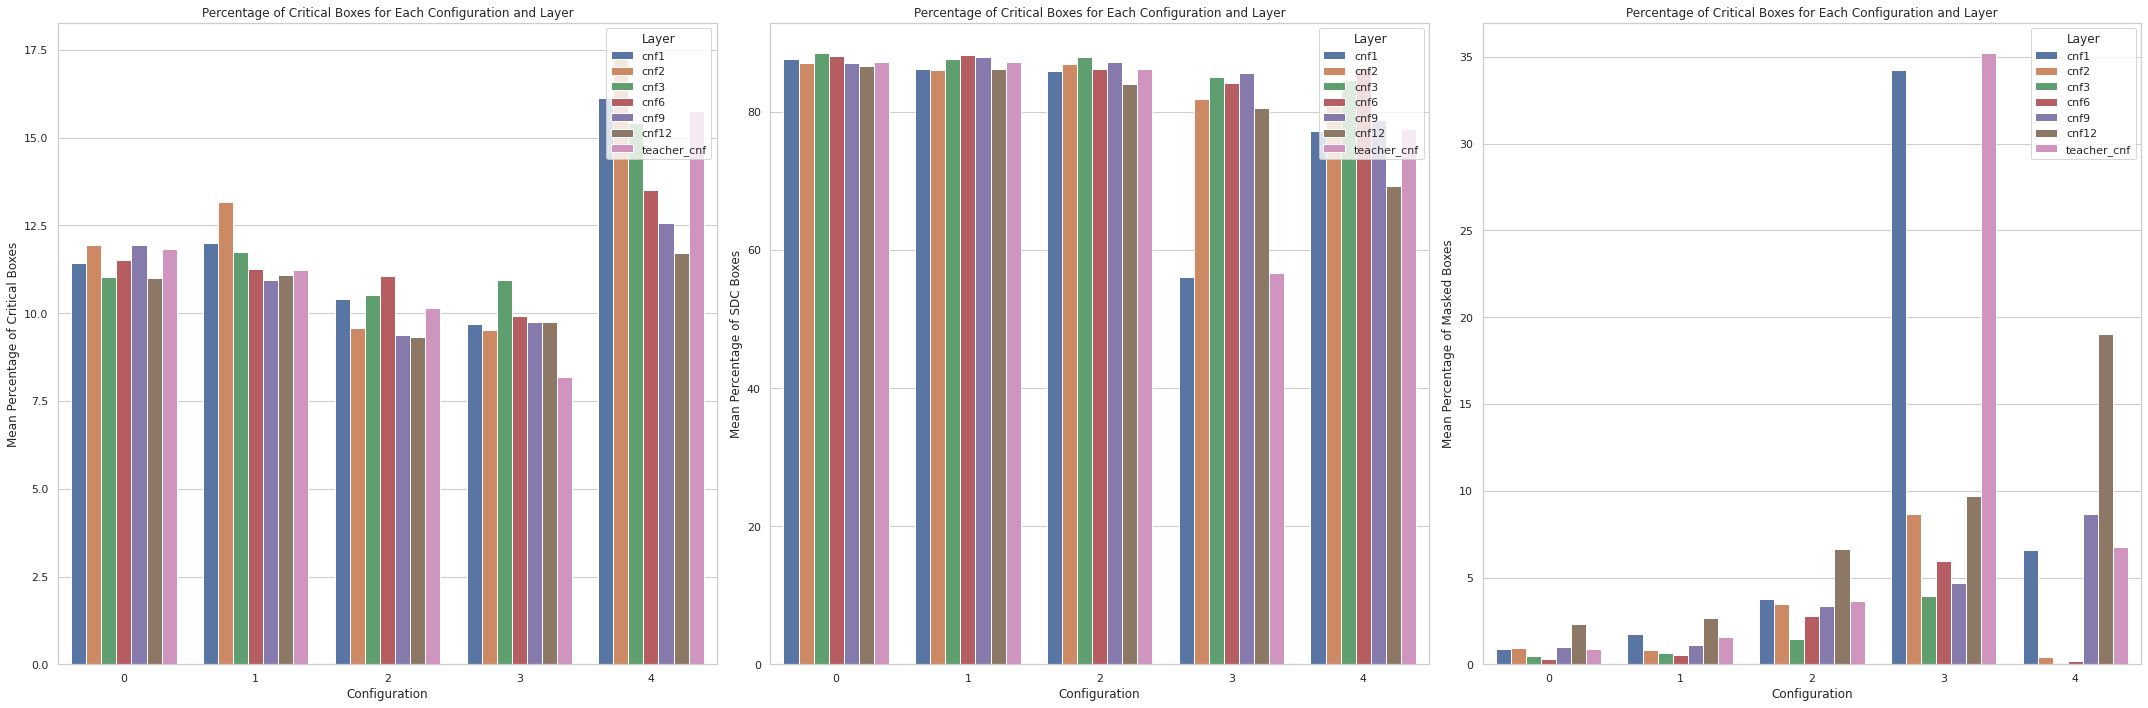

In [22]:
mean_percentages_crit = general_report.groupby(['conf_detail', 'layer'])['Crit_perc'].mean().reset_index()
mean_percentages_sdc = general_report.groupby(['conf_detail', 'layer'])['SDC_perc'].mean().reset_index()
mean_percentages_masked = general_report.groupby(['conf_detail', 'layer'])['masked_perc'].mean().reset_index()

fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.set(style='whitegrid')
sns.barplot(x='layer', y='Crit_perc', hue='conf_detail', data=mean_percentages_crit, ax = ax[0])
ax[0].set_xlabel('Configuration')
ax[0].set_ylabel('Mean Percentage of Critical Boxes')
ax[0].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[0].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='layer', y='SDC_perc', hue='conf_detail', data=mean_percentages_sdc, ax = ax[1])
ax[1].set_xlabel('Configuration')
ax[1].set_ylabel('Mean Percentage of SDC Boxes')
ax[1].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[1].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='layer', y='masked_perc', hue='conf_detail', data=mean_percentages_masked, ax = ax[2])
ax[2].set_xlabel('Configuration')
ax[2].set_ylabel('Mean Percentage of Masked Boxes')
ax[2].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[2].legend(title='Layer', loc='upper right')
plt.tight_layout()

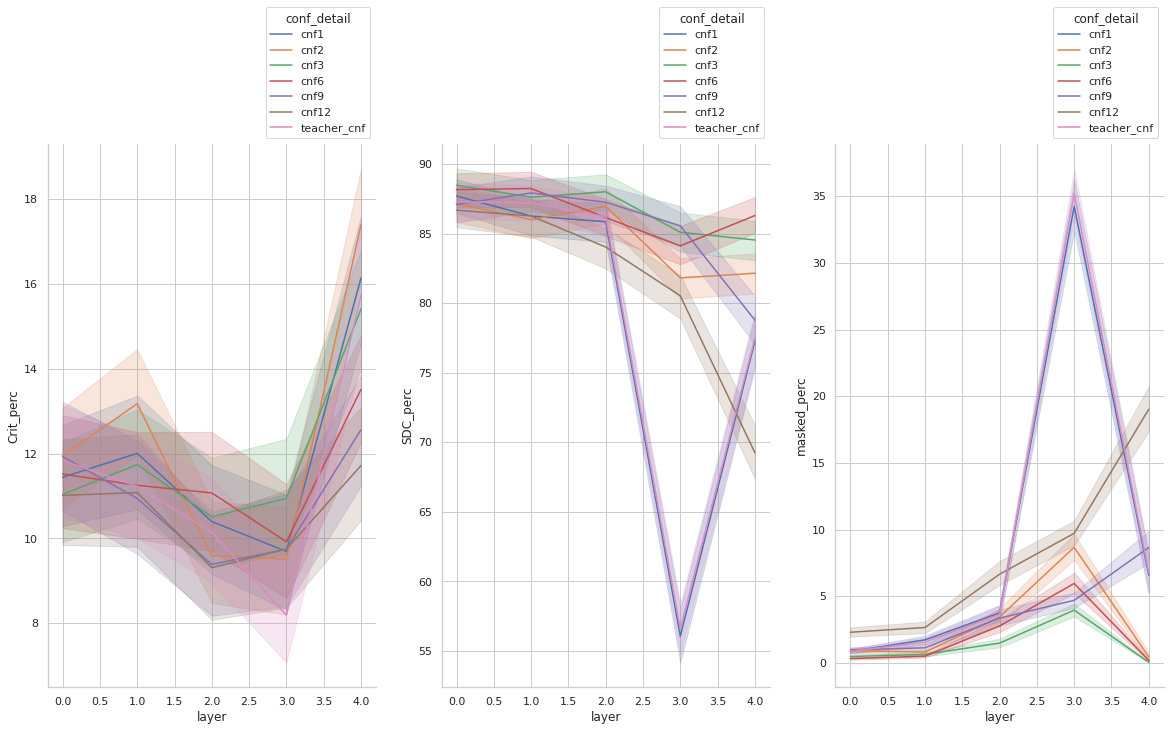

In [23]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
# ax[0].grid()
sns.lineplot(data=general_report, x='layer', y='Crit_perc', ax=ax[0], hue ='conf_detail')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
# ax[1].grid()
sns.lineplot(data=general_report, x='layer', y='SDC_perc', ax=ax[1],hue ='conf_detail')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
# ax[2].grid()
sns.lineplot(data=general_report, x='layer', y='masked_perc', ax=ax[2], hue ='conf_detail')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))


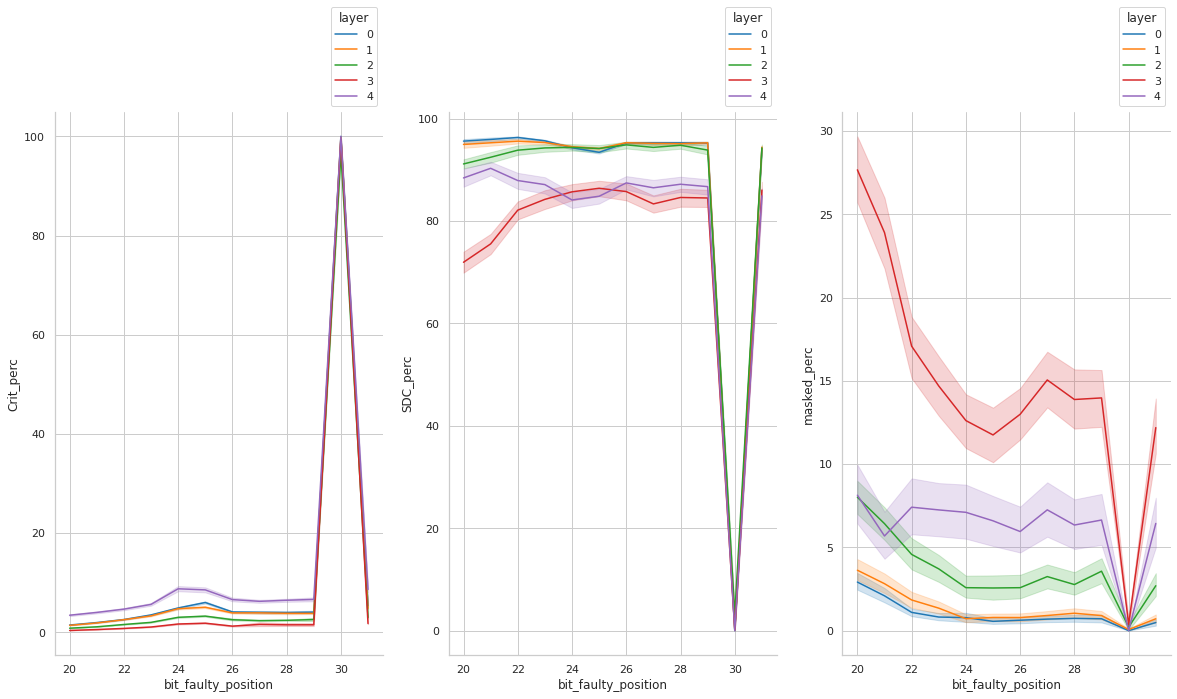

In [24]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='Crit_perc', ax=ax[0], hue ='layer', palette='tab10')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
# ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='SDC_perc', ax=ax[1],hue ='layer', palette='tab10')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
# ax[1].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='masked_perc', ax=ax[2], hue ='layer', palette='tab10')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
# ax[2].grid()

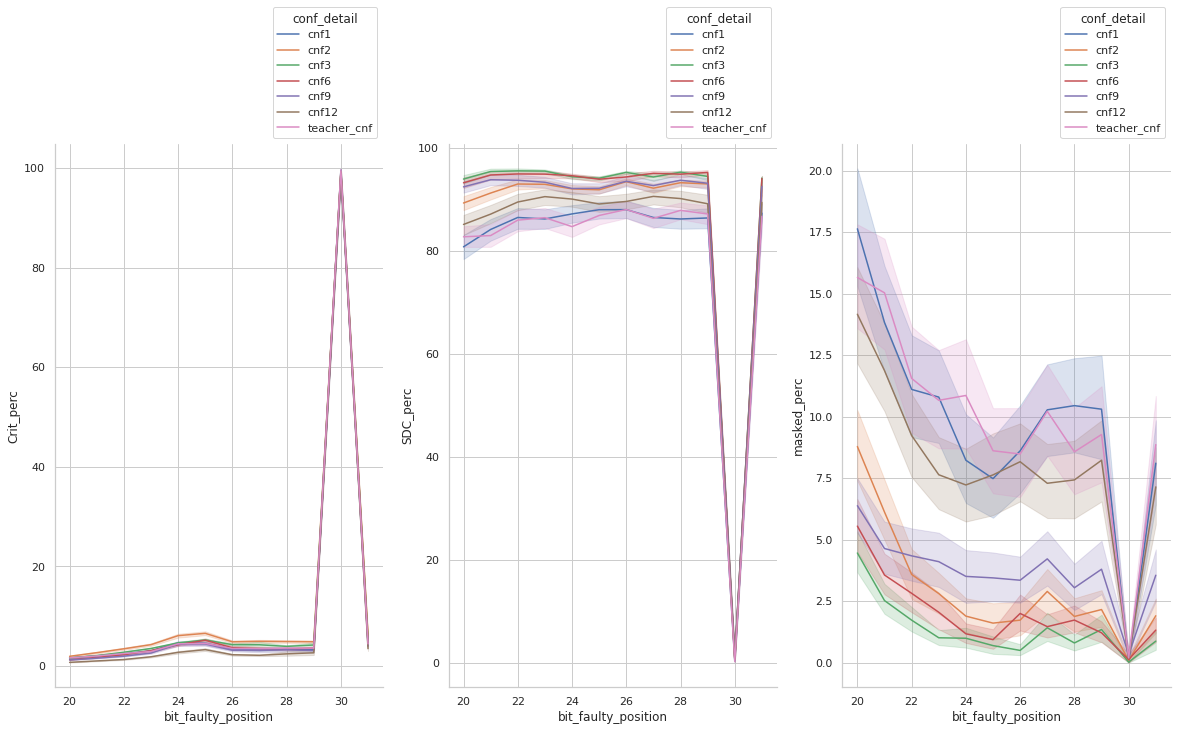

In [25]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='Crit_perc', ax=ax[0], hue ='conf_detail')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
# ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='SDC_perc', ax=ax[1],hue ='conf_detail')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
# ax[1].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='masked_perc', ax=ax[2], hue ='conf_detail')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
# ax[2].grid()


## Results:
- how the SDC should be interpreted? because the reasons why records are labeled as SDC are different. 

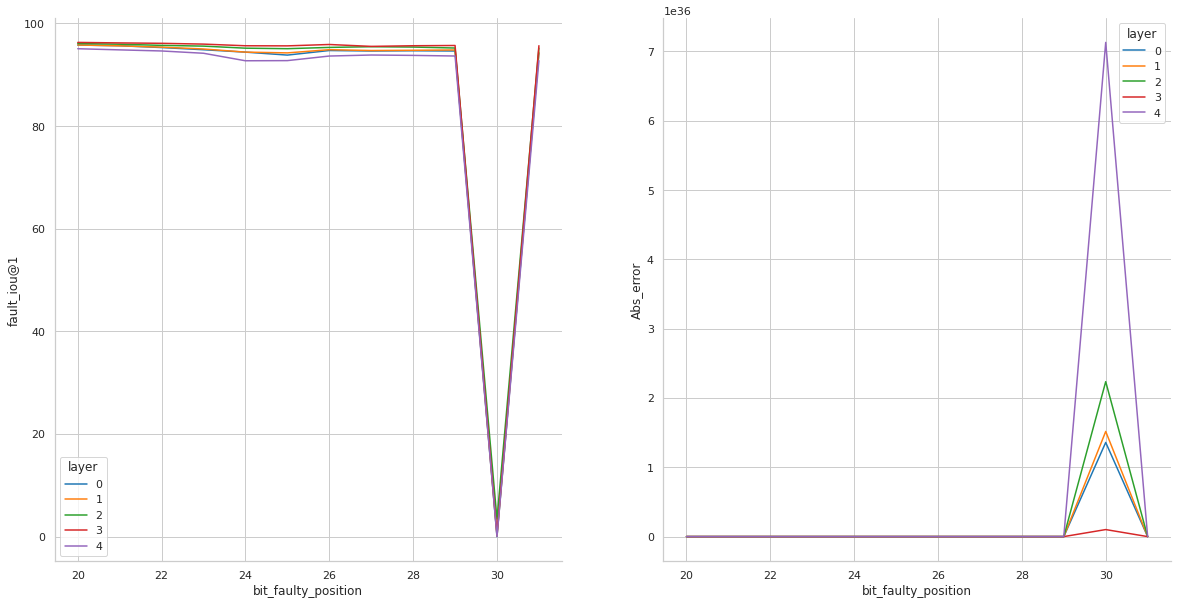

In [26]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='fault_iou@1', ax=ax[0], hue ='layer', palette="tab10", ci=None)
# ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='Abs_error', ax=ax[1], hue ='layer', palette="tab10", ci=None)
# ax[1].grid()

In [27]:
general_report[general_report['bitmask'] == 1073741824]

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,conf_detail,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
10851,3,39,241,0,0,1073741824,68.352722,505,0,0,...,7.78,3.0,3.174932e+09,4.248674e+09,1.575263e+37,cnf1,30.0,100.0,0.0,0.0
10862,3,37,76,1,1,1073741824,68.352722,505,0,0,...,7.78,3.0,3.148867e+09,4.222609e+09,1.826645e+36,cnf1,30.0,100.0,0.0,0.0
10889,3,0,30,1,0,1073741824,68.352722,505,0,0,...,7.78,3.0,3.180256e+09,4.253998e+09,2.373588e+37,cnf1,30.0,100.0,0.0,0.0
10895,3,26,172,0,0,1073741824,68.352722,505,0,0,...,7.78,3.0,3.187659e+09,4.261400e+09,4.250377e+37,cnf1,30.0,100.0,0.0,0.0
10880,3,27,44,1,1,1073741824,68.352722,43,0,0,...,7.78,3.0,3.201357e+09,4.275099e+09,1.387902e+38,cnf1,30.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24506,4,0,43,1,0,1073741824,68.352722,505,0,0,...,7.78,4.0,9.804549e+08,2.054197e+09,-3.122568e+35,teacher_cnf,30.0,100.0,0.0,0.0
24510,4,0,54,0,1,1073741824,68.352722,505,0,0,...,7.78,4.0,1.021993e+09,2.095734e+09,-9.735308e+36,teacher_cnf,30.0,100.0,0.0,0.0
24515,4,0,31,1,1,1073741824,68.352722,505,0,0,...,7.78,4.0,3.192834e+09,4.266576e+09,6.871558e+37,teacher_cnf,30.0,100.0,0.0,0.0
24486,4,0,63,0,0,1073741824,68.352722,505,0,0,...,7.78,4.0,1.041760e+09,2.115502e+09,-5.050956e+37,teacher_cnf,30.0,100.0,0.0,0.0


In [1]:
to_melt = general_report[['layer','Crit_perc', 'SDC_perc', 'masked_perc']]
df_melted = to_melt.melt(id_vars='layer', var_name='box_type', value_name='box_perc')

NameError: name 'general_report' is not defined

In [2]:
# print(df_melted[df_melted['box_perc']==0]['layer'].value_counts())

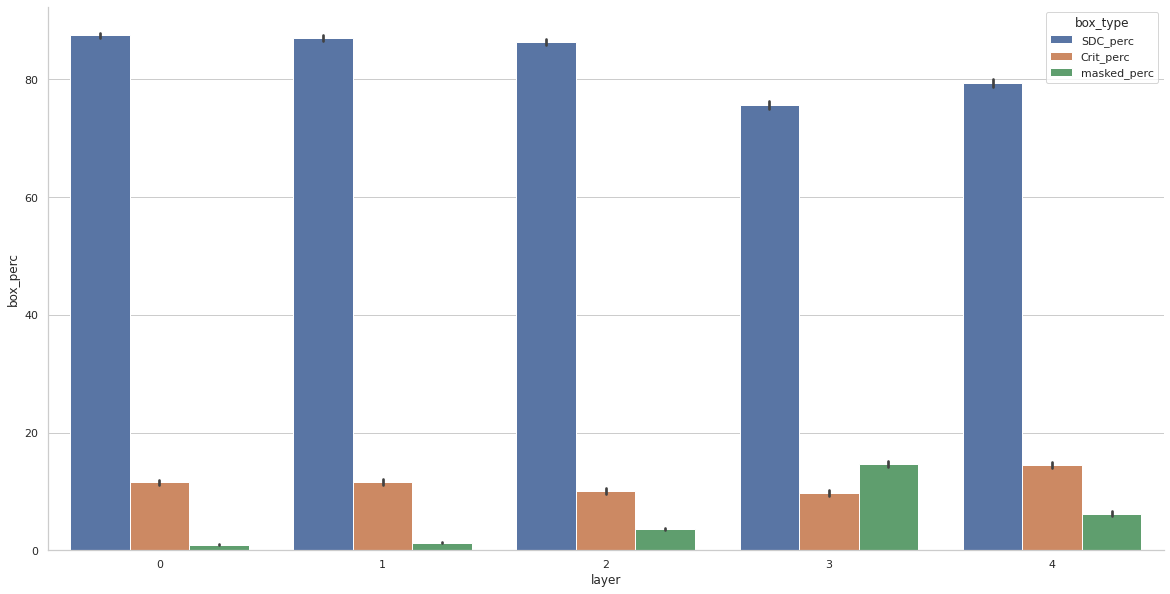

In [30]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.barplot(x='layer', y='box_perc', hue='box_type', data=df_melted, ax=ax)
# ax.grid()
# ax.set_yscale('log')

The percentage of critical boxes over all the predicted ones have an almost stable trend. On the other hand, the percentage of masked boxes have a slight increasing trend. 

## Clustering

In [31]:
general_report

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,conf_detail,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
10408,3,29,234,0,1,134217728,68.352722,0,459,46,...,7.78,3.0,3.166019e+09,3.031802e+09,-0.022171,cnf1,27.0,0.000000,90.891089,9.108911
10842,3,60,118,1,1,268435456,68.352722,0,0,505,...,7.78,3.0,3.197499e+09,2.929064e+09,-0.292910,cnf1,28.0,0.000000,0.000000,100.000000
10843,3,33,178,0,1,134217728,68.352722,2,496,7,...,7.78,3.0,3.154601e+09,3.020384e+09,-0.008264,cnf1,27.0,0.396040,98.217822,1.386139
10844,3,3,244,0,0,8388608,68.352722,1,423,81,...,7.78,3.0,1.037333e+09,1.028944e+09,0.051865,cnf1,23.0,0.198020,83.762376,16.039604
10845,3,31,248,1,1,2097152,68.352722,0,233,272,...,7.78,3.0,3.216184e+09,3.214087e+09,-0.250000,cnf1,21.0,0.000000,46.138614,53.861386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24494,4,0,36,0,1,1048576,68.352722,24,481,0,...,7.78,4.0,3.175365e+09,3.176414e+09,0.003906,teacher_cnf,20.0,4.752475,95.247525,0.000000
24495,4,0,7,1,1,536870912,68.352722,66,439,0,...,7.78,4.0,1.057064e+09,5.201932e+08,0.505934,teacher_cnf,29.0,13.069307,86.930693,0.000000
24496,4,0,16,0,0,67108864,68.352722,36,469,0,...,7.78,4.0,3.190337e+09,3.123229e+09,-0.164089,teacher_cnf,26.0,7.128713,92.871287,0.000000
24488,4,0,60,0,0,2147483648,68.352722,0,5,500,...,7.78,4.0,9.725723e+08,3.120056e+09,0.000947,teacher_cnf,31.0,0.000000,0.990099,99.009901


In [32]:
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')

In [33]:
clustering_df = general_report[['conf_detail', 'fault_iou@1', 'bit_faulty_position', 'area_ratio', 'layer']]

(0.0, 400.0)

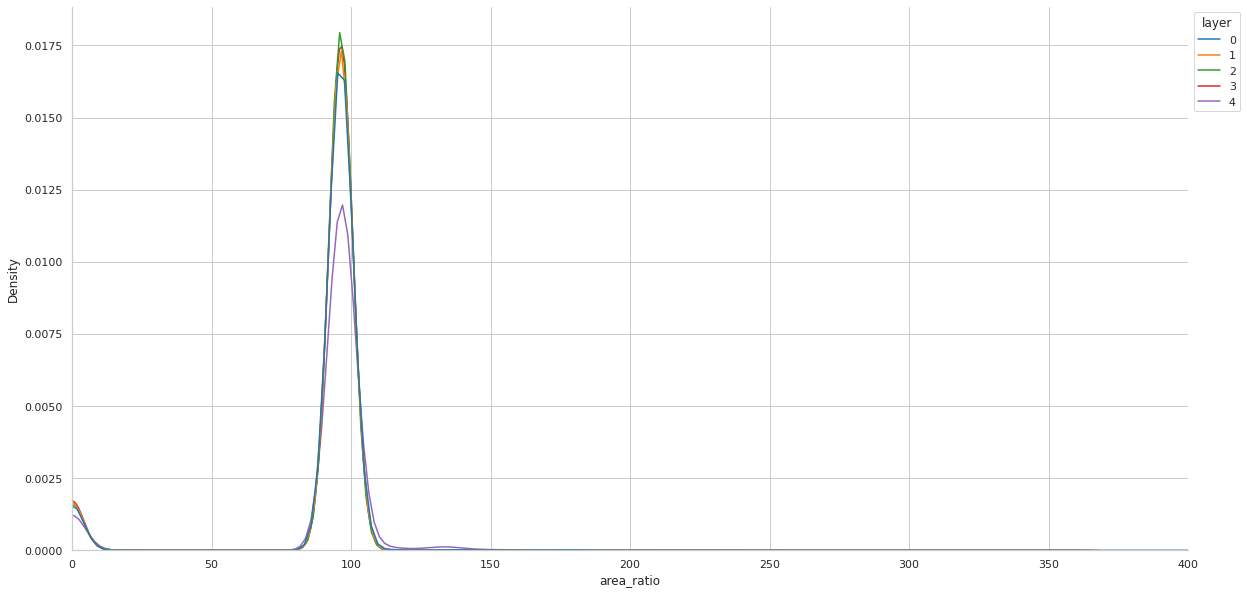

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'area_ratio', data=clustering_df, hue = 'layer', palette="tab10")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 400)
# ax.grid()

(0.0, 100.0)

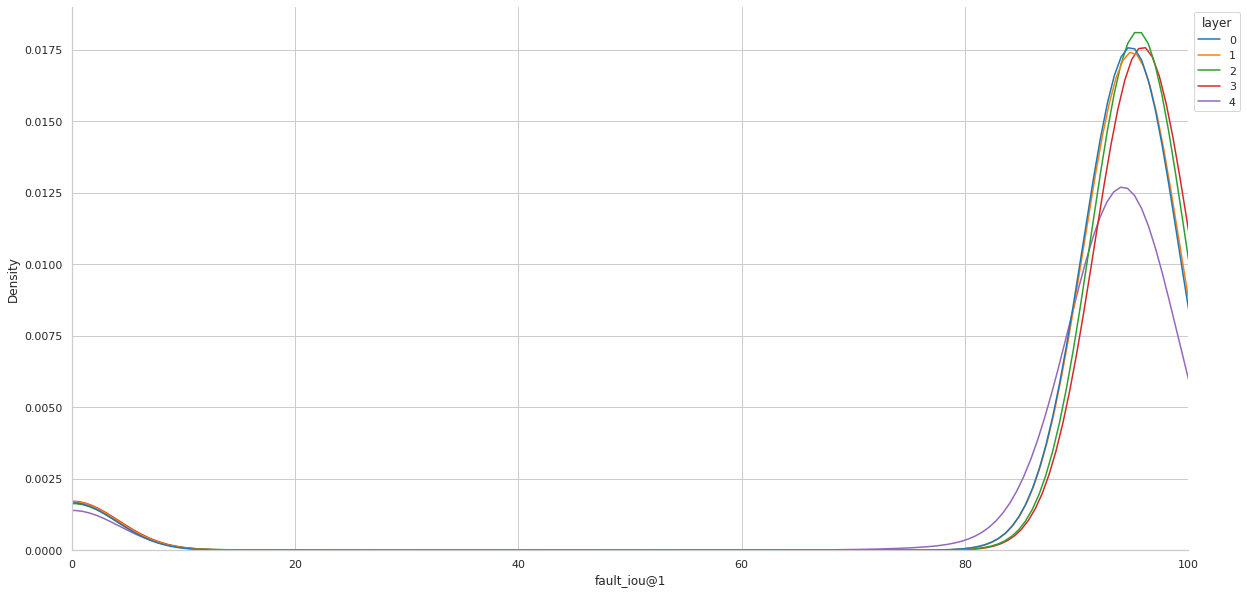

In [35]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'fault_iou@1', data=clustering_df, hue = 'layer', palette="tab10")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.grid()
ax.set_xlim(0, 100)

In [36]:
print(general_report.columns)
scaler = MinMaxScaler((0,1))
to_scale = general_report.drop(columns=['conf_detail', 'gold_iou@1', 'Class', 'layer', 'Abs_error'])
scaled_report = scaler.fit_transform(to_scale)
# scaled_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')


In [37]:
kmeans = KMeans(
    n_clusters=5,
    init="random",
    n_init=10,
    max_iter=20,
    random_state=42
)


In [38]:
true_labels = general_report['layer']
secondary_labels = general_report['conf_detail']

# Drop the true labels column to prepare the data for clustering
# X = scaled_report.drop(columns=['layer', 'conf_detail'])

# Apply K-means clustering with k=3 (number of clusters, you can adjust this)
n_clusters = len(true_labels.unique())
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(scaled_report)

# Calculate the Adjusted Rand Index (ARI) to evaluate the clustering performance
ari = adjusted_rand_score(true_labels, cluster_assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

Adjusted Rand Index (ARI): 0.14111217743576782


In [39]:
dbscan = DBSCAN(
    eps=0.5,
    min_samples=10,
    metric='cosine'
)

In [40]:
dbscan.fit(scaled_report)
dbscan.labels_

: 

: 

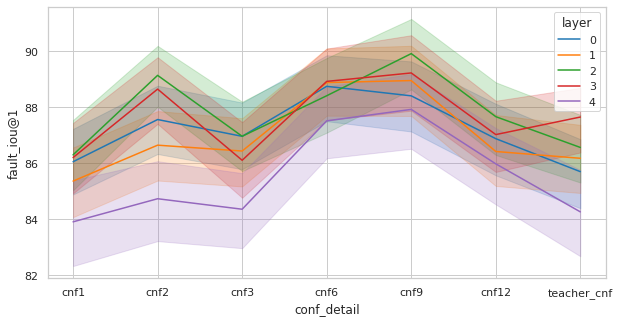

In [24]:
# Create the line plot with the sorted data
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(x='conf_detail', y='fault_iou@1', data=general_report, hue='layer', palette='tab10')
# ax.grid()

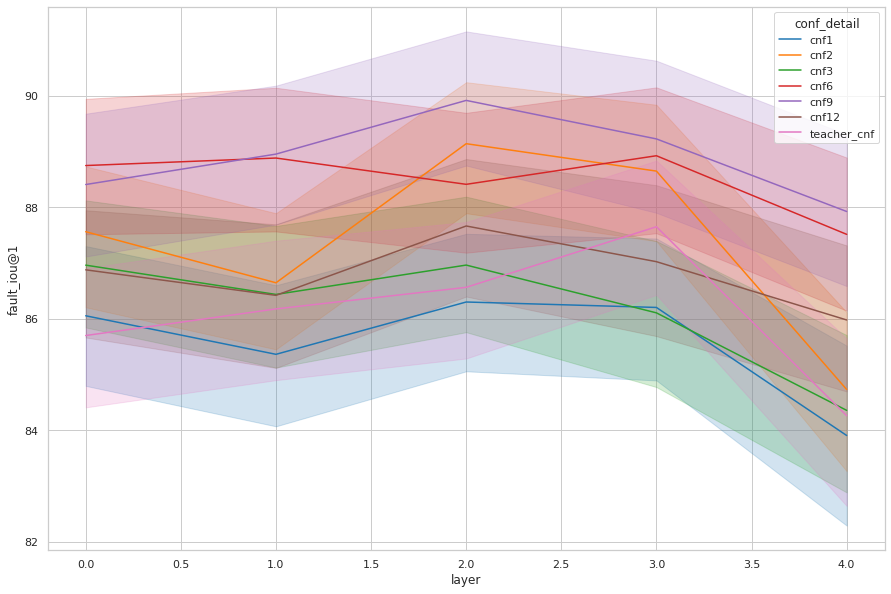

In [25]:
# Define the desired order of the categories
# desired_order = ['cnf1', 'cnf2', 'cnf3', 'cnf6', 'cnf9', 'cnf12', 'teacher_cnf']

# # Sort the data by the categorical variable
# data_sorted = general_report.sort_values(by='conf_detail')
# data_sorted['conf_detail'] = data_sorted['conf_detail'].astype('category')
# data_sorted['conf_detail'].cat.reorder_categories(desired_order, inplace=True)

# Create the line plot with the sorted data
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.lineplot(x='layer', y='fault_iou@1', data=general_report, hue='conf_detail', palette='tab10')
# ax.grid()

In [30]:
100-general_report.groupby(by=['conf_detail', 'layer']).mean()['fault_iou@1'].unstack()

layer,0,1,2,3,4
conf_detail,,,,,
cnf1,13.947165,14.638297,13.700024,13.797513,16.094248
cnf2,12.439177,13.355176,10.860529,11.351995,15.268815
cnf3,13.038997,13.564438,13.037654,13.894682,15.643472
cnf6,11.252479,11.117729,11.589348,11.076473,12.486470
cnf9,11.592888,11.047002,10.084109,10.774723,12.076510
cnf12,13.122943,13.580702,12.336582,12.976680,14.022320
teacher_cnf,14.301252,13.824019,13.436750,12.349864,15.738489
